In [87]:
import string
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [258]:
data = pd.read_csv('spam_or_not_spam.csv', encoding = 'latin-1')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [259]:
# data['Spam/Ham'] = data['label'].map({0 : 'ham', 1 : 'spam'})
# data.head()

In [260]:
data = data.loc[~data.index.isin([2896, 2966])]

In [261]:
data['label'].value_counts()

0    2500
1     498
Name: label, dtype: int64

In [262]:
from sklearn.utils import resample
def data_resapmling(df):
    df_0 = df[df.label==0]
    df_1 = df[df.label==1]
    
    no_1 = int(len(df_0))

    df_1_b = resample(df_1,
                      replace=True,     
                      n_samples=no_1,  
                      random_state=123) 

    df_b = pd.concat([df_0, df_1_b])  # Oversample
    return df_b

data = data_resapmling(data)
data['label'].value_counts()

1    2500
0    2500
Name: label, dtype: int64

In [263]:
# d = data.loc[data['label'] == 1, 'email']
# d[]
# [x for x in d]
# data.iloc[2870:2940]


In [264]:
data = data.sample(n = len(data), random_state = 42)
data = data.reset_index(drop = True)

In [265]:
def plot_wordcloud(data, labels):
#     d = data.loc[data['label'] == 1, 'email']
#     dd = [x for x in d]
    words = ' '.join(list(data.loc[data['label'] == labels, 'email']))
    wc = WordCloud(width = 512,height = 512).generate(words)
    plt.figure(figsize = (10, 8), facecolor = 'k')
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

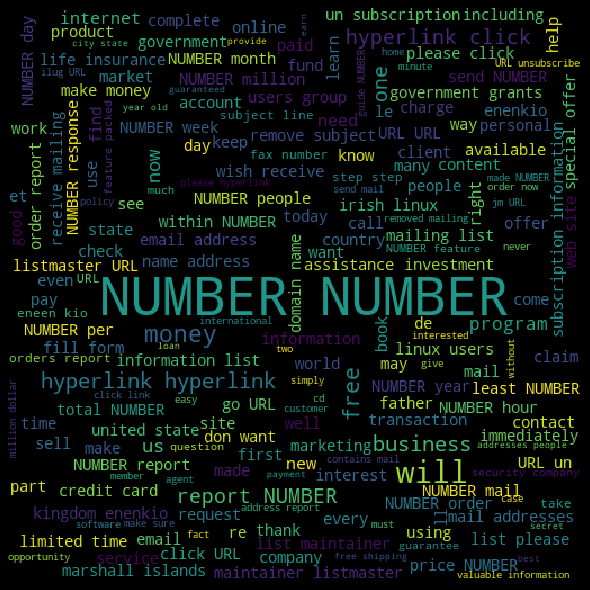

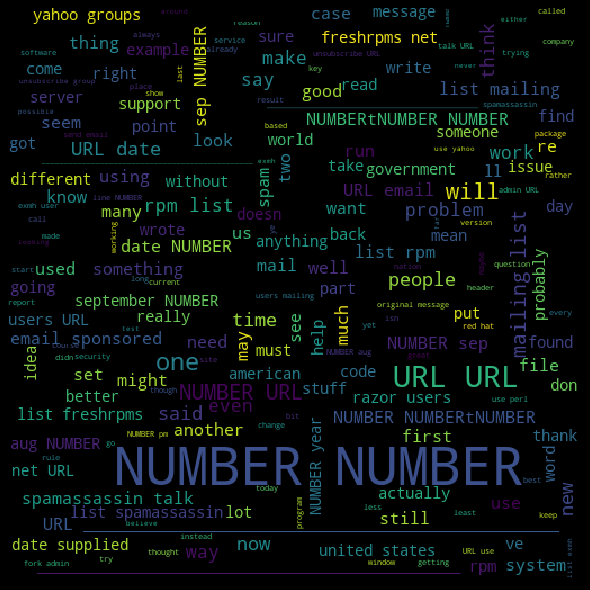

In [254]:
plot_wordcloud(data, 1)
plot_wordcloud(data, 0)

In [246]:
# calculate accurecy
def calculate_accurecy(y_pred_pro, y_true, y_pred):   
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    F1 = 2*(precision*recall)/(precision+recall)
    roc = roc_auc_score(y_true, y_pred_pro)
    print('accuracy:%.5f'%accuracy)
    print('recall:%.5f'%recall)
    print('precision:%.5f'%precision)
    print('F1:%.5f'%F1)
    print('ROC:%.5f'%roc)
    return accuracy, recall, precision, F1, roc

def ConfusionMatrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm,['Ham', 'Spam'], ['Ham','Spam'])                      
    f, ax = plt.subplots(figsize=(6, 4))
    sn.heatmap(cm_df, annot=True, fmt="d")
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    

In [247]:
def model_logistic(X_train, X_test, y_train, y_test):
#     vectorizer = TfidfVectorizer("english")
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
#     model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train,y_train)
    model = LogisticRegression(solver='liblinear').fit(X_train,y_train)

    print('\n --- Training Acuurecy---\n')
    y_pred = model.predict(X_train)
    y_pred_pro = model.predict_proba(X_train)[:, 1]
    calculate_accurecy(y_pred_pro, y_train, y_pred)
    print('\n --- Test Acuurecy---\n')
    y_pred = model.predict(X_test)
    y_pred_pro = model.predict_proba(X_test)[:, 1]
    calculate_accurecy(y_pred_pro, y_test, y_pred)
    title = "Confusion Matrix (Logistic Regression)"
    ConfusionMatrix(y_test, y_pred, title)
    return model, vectorizer

def model_randomForest(X_train, X_test, y_train, y_test):
#     vectorizer = TfidfVectorizer("english")
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    model = RandomForestClassifier().fit(X_train,y_train)

    print('\n --- Training Acuurecy---\n')
    y_pred = model.predict(X_train)
    y_pred_pro = model.predict_proba(X_train)[:, 1]
    calculate_accurecy(y_pred_pro, y_train, y_pred)
    print('\n --- Test Acuurecy---\n')
    y_pred = model.predict(X_test)
    y_pred_pro = model.predict_proba(X_test)[:, 1]
    calculate_accurecy(y_pred_pro, y_test, y_pred)
    title = "Confusion Matrix (Logistic Regression)"
    ConfusionMatrix(y_test, y_pred, title)
    return model, vectorizer

In [225]:
def remove_punctuations(data_input):
    exclude = set(string.punctuation)
    tx = list()
    for xx in data_input:
        text = ''.join([ch for ch in xx if ch not in exclude])
        tx.append(text)
    return pd.Series(tx)

def remove_number(data_input):
    tx = list()
    for xx in data_input:
        text = ''.join([i for i in xx if not i.isdigit()])
        tx.append(text)
    return pd.Series(tx)

def separate_number_string(data_input):
    import re
    txt = list()
    for xx in data_input:
        tlist = list()
        for s in xx.split():
            tx = ' '.join([i for i in re.split(r'(\d+)', s) if i])
            tlist.append(tx)
        txt0 = ' '.join(tlist)
        txt.append(txt0)
    return pd.Series(txt)

def remove_stop_word(data_input):
    stop_word = set(stopwords.words('english'))
    tx = list()
    for xx in data_input:
        text = ' '.join([word for word in xx.split() if word.lower() not in stop_word])
        tx.append(text)
    return pd.Series(tx)

def Stemmer_Porter(data_input):
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    tx = list()
    for xx in data_input:
        tex = ' '.join([ps.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_Snowball(data_input):
    from nltk.stem.snowball import SnowballStemmer
    snow = SnowballStemmer("english")
    tx = list()
    for xx in data_input:
        tex = ' '.join([snow.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_Lancaster(data_input):
    from nltk.stem.lancaster import LancasterStemmer
    lan = LancasterStemmer()
    tx = list()
    for xx in data_input:
        tex = ' '.join([lan.stem(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

def Stemmer_WordNetLemmatizer(data_input):
    from nltk.stem import WordNetLemmatizer 
    lemmatizer = WordNetLemmatizer() 
    tx = list()
    for xx in data_input:
        tex = ' '.join([lemmatizer.lemmatize(word) for word in xx.split()])
        tx.append(tex)
    return pd.Series(tx)

In [226]:
def pre_process(stemmer_lists, email_input):
    for stremmer in stemmer_lists:
        email_input = stremmer(email_input)

    return email_input



 --- Training Acuurecy---

accuracy:1.00000
recall:1.00000
precision:1.00000
F1:1.00000
ROC:1.00000

 --- Test Acuurecy---

accuracy:0.99440
recall:0.99440
precision:0.99446
F1:0.99443
ROC:0.99996


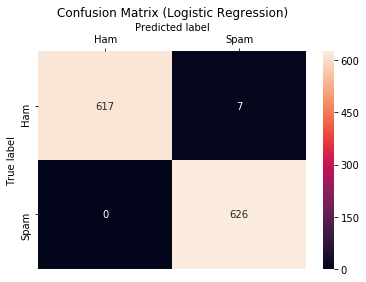

In [266]:
stemmer_lists = [remove_punctuations, remove_stop_word, separate_number_string, Stemmer_Porter, Stemmer_WordNetLemmatizer]
X = pre_process(stemmer_lists, data['email'])
# X = data['email']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
# model, vectorizer = model_logistic(X_train, X_test, y_train, y_test)
model, vectorizer = model_randomForest(X_train, X_test, y_train, y_test)


In [209]:
## Check Single email/SMS
tx00 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
tx01 = pd.Series(tx00)
X_check = pre_process(stemmer_lists, tx01)
text_vect = vectorizer.transform(X_check)
prediction = model.predict(text_vect)
print("The Email is: ", tx00, '\n')
# print("The Email is: ", X_check, '\n')
print('This Email is', 'NOT SPAM' if prediction == 0 else 'SPAM')


The Email is:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

This Email is NOT SPAM


In [210]:
X_test_vec = vectorizer.transform(X_test)
y_pred = model.predict(X_test_vec)

In [211]:
## False-Positive 
X_test[(y_pred == 0) & (y_test == 1)]

278     guarante signup ever pay penni show green ever...
12      hallo found email id director russian man like...
1761    x h c x u x u z q b h n x z w n z b x z z p u ...
1963    get access largest free adult site net url num...
2040    guarante signup ever pay penni show green ever...
1449    foreword thirti three year black man live ghet...
2674    gbnumber b ynwnumbersqunumberrunumbernbqufqnum...
947     url email sponsor osdn tire old cell phone get...
317     sent e mail messag enenkio url robert moor dat...
1252    url promot product servic thousand classifi si...
1957    degerli smstr kullanicimiz sm programimiz esit...
1830    hi job seeker creat free net temp account acce...
dtype: object

Using TensorFlow backend.


The Uper Sampler:  RandomOverSampler

 --- Training Acuurecy---

accuracy:0.99840
recall:0.99840
precision:0.99841
F1:0.99840
ROC:1.00000

 --- Test Acuurecy---

accuracy:0.99440
recall:0.99440
precision:0.99440
F1:0.99440
ROC:0.99995
 
The Uper Sampler:  SMOTE


ValueError: could not convert string to float: 'wednesday number august number number number pm daniel quinlan wrote matthew cline matt nightrealm com write must way track spammer sinc plan make money spam court would consid evid spammer anoth question haha note difficult find prosecut win money someon variou non friendli countri spam origin china good exampl even offici respect copyright law sa filter could configur ignor swe mark appear come china spammer alway rememb includ contact inform understand either nobodi said bright also spam non commerci sent third parti exampl pump dump stock scam contact inform strictli requir spammer get way sa could also configur swe mark ignor messag look like third parti spam like stock scam cours would still mean u n go invad america spam swe would get probabl also need ignor swe messag look like nigerian scam give man match warm minut set fire warm rest life icq number advanc spam filter softwar url url email sponsor jabber world fastest grow real time commun platform im build url spamassassin talk mail list spamassassin talk url url'

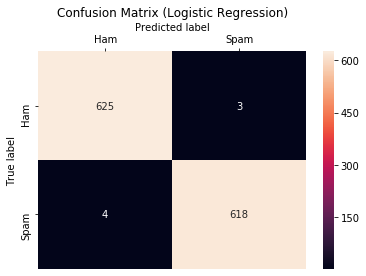

In [212]:
# imbalanced data SMOTE
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE,KMeansSMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE 
resmaplers = [('RandomOverSampler', RandomOverSampler() )]
#           ('ADASYN', ADASYN() ),
#           ('SMOTE', SMOTE( ) )
#           ('KMeansSMOTE', KMeansSMOTE(random_state=42) ), 
#           ('BorderlineSMOTE', BorderlineSMOTE(random_state=42) ), 
#           ('SMOTENC', SMOTENC(random_state=42, categorical_features=[18, 19]) ) 
#           ('SVMSMOTE', SVMSMOTE(random_state=42) ) 
#          ]
X_imb = X.to_numpy().reshape(-1,1)
y_imb = y.to_numpy().reshape(-1,1)

for name, resmapler in resmaplers:
    print('The Uper Sampler: ', name)
    X_blanced, y_blanced = resmapler.fit_resample(X_imb, y_imb)
    X_train, X_test, y_train, y_test = train_test_split(X_blanced, y_blanced, random_state=5)
    X_train = X_train.reshape(-1)
    X_test = X_test.reshape(-1)
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)
    model, vectorizer = model_logistic(X_train, X_test, y_train, y_test)
    print(" ")
# X_imb.shape  